In [3]:
%load_ext autoreload
%autoreload 2
import sys
from example_utils import generate_dms_data, 
import matplotlib
import matplotlib.pyplot as plt
import dms, ranktwo, clustering
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ModuleNotFoundError: No module named 'low_rank_rnns'

In [2]:
matplotlib.rcParams['figure.figsize'] = (6, 5)
matplotlib.rcParams['font.size'] = 40
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['axes.titlesize'] = 'medium'
matplotlib.rcParams['xtick.labelsize'] = 40
matplotlib.rcParams['ytick.labelsize'] = 40
#matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False

# Load trained model

In [3]:
hidden_size = 500
noise_std = 5e-2
alpha = 0.2
x_train, y_train, mask_train, x_val, y_val, mask_val = generate_dms_data(1000)
net =  LowRankRNN(2, hidden_size, 1, noise_std, alpha, rank=2)
net.load_state_dict(torch.load(f'../models/dms_rank2_{hidden_size}.pt', map_location='cpu'))
net.svd_reparametrization()

In [5]:
loss_orig, acc_orig = dms.test_dms(net, x_val, y_val, mask_val)
print(acc_orig)
print(loss_orig)

1.0
0.007068399339914322


# Visualising two network populations

In [8]:
n_pops = 2
z, _ = clustering.gmm_fit(net, n_pops, algo='bayes', random_state=2020)  # z will contain labels for the 2 populations

pop 0: slope=-0.01, intercept=-0.04
pop 1: slope=-0.03, intercept=0.06
pop 0: slope=-0.01, intercept=0.02
pop 1: slope=-0.02, intercept=-0.20


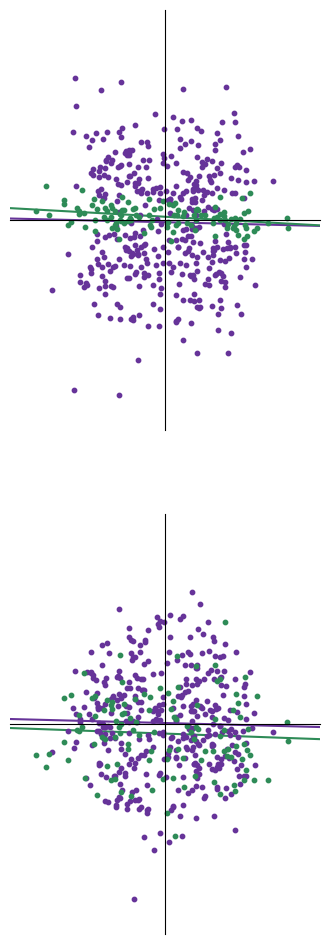

In [9]:
# Visualizing those 2 populations
m = net.m[:,0].detach().numpy()
n = net.n[:,0].detach().numpy() 
wi1 = net.wi[0].detach().numpy()
wi2 = net.wi[1].detach().numpy()

fig, ax = plt.subplots(2, 1, figsize=(4, 12))
colors = ['rebeccapurple', 'seagreen']
fs = 12
clustering.pop_scatter_linreg(n, wi1, z, n_pops, colors=colors, ax=ax[0])
clustering.pop_scatter_linreg(n, wi2, z, n_pops, colors=colors, ax=ax[1])

# Create new network by fitting Gaussian mixture to the connectivity space

In [10]:
net3 = clustering.to_support_net(net, z, scaling=True)

Check that the resampled networks still give the same validation losses

In [13]:
accs2 = []
for _ in range(10):
    net3.resample_basis()
    loss, acc = dms.test_dms(net3, x_val, y_val, mask_val)
    accs2.append(acc)

Train net network for a few epochs

In [15]:
train(net3, x_train, y_train, mask_train, 20, lr=1e-6, resample=True, keep_best=True, clip_gradient=1)

Training...
initial loss: 1.187
epoch 0:  loss=1.129  (took 7.78 s) *
epoch 1:  loss=1.147  (took 7.55 s)
epoch 2:  loss=1.127  (took 8.17 s) *
epoch 3:  loss=1.103  (took 8.39 s) *
epoch 4:  loss=1.106  (took 7.75 s)
epoch 5:  loss=1.136  (took 7.09 s)
epoch 6:  loss=1.140  (took 6.47 s)
epoch 7:  loss=1.146  (took 7.30 s)
epoch 8:  loss=1.136  (took 7.75 s)
epoch 9:  loss=1.132  (took 7.89 s)
epoch 10:  loss=1.121  (took 6.75 s)
epoch 11:  loss=1.120  (took 7.29 s)
epoch 12:  loss=1.110  (took 7.16 s)
epoch 13:  loss=1.140  (took 7.60 s)
epoch 14:  loss=1.164  (took 7.03 s)
epoch 15:  loss=1.122  (took 6.66 s)
epoch 16:  loss=1.153  (took 6.91 s)
epoch 17:  loss=1.100  (took 6.67 s) *
epoch 18:  loss=1.094  (took 7.07 s) *
epoch 19:  loss=1.132  (took 7.22 s)


# Plot phase portraits of the original system for various parameters

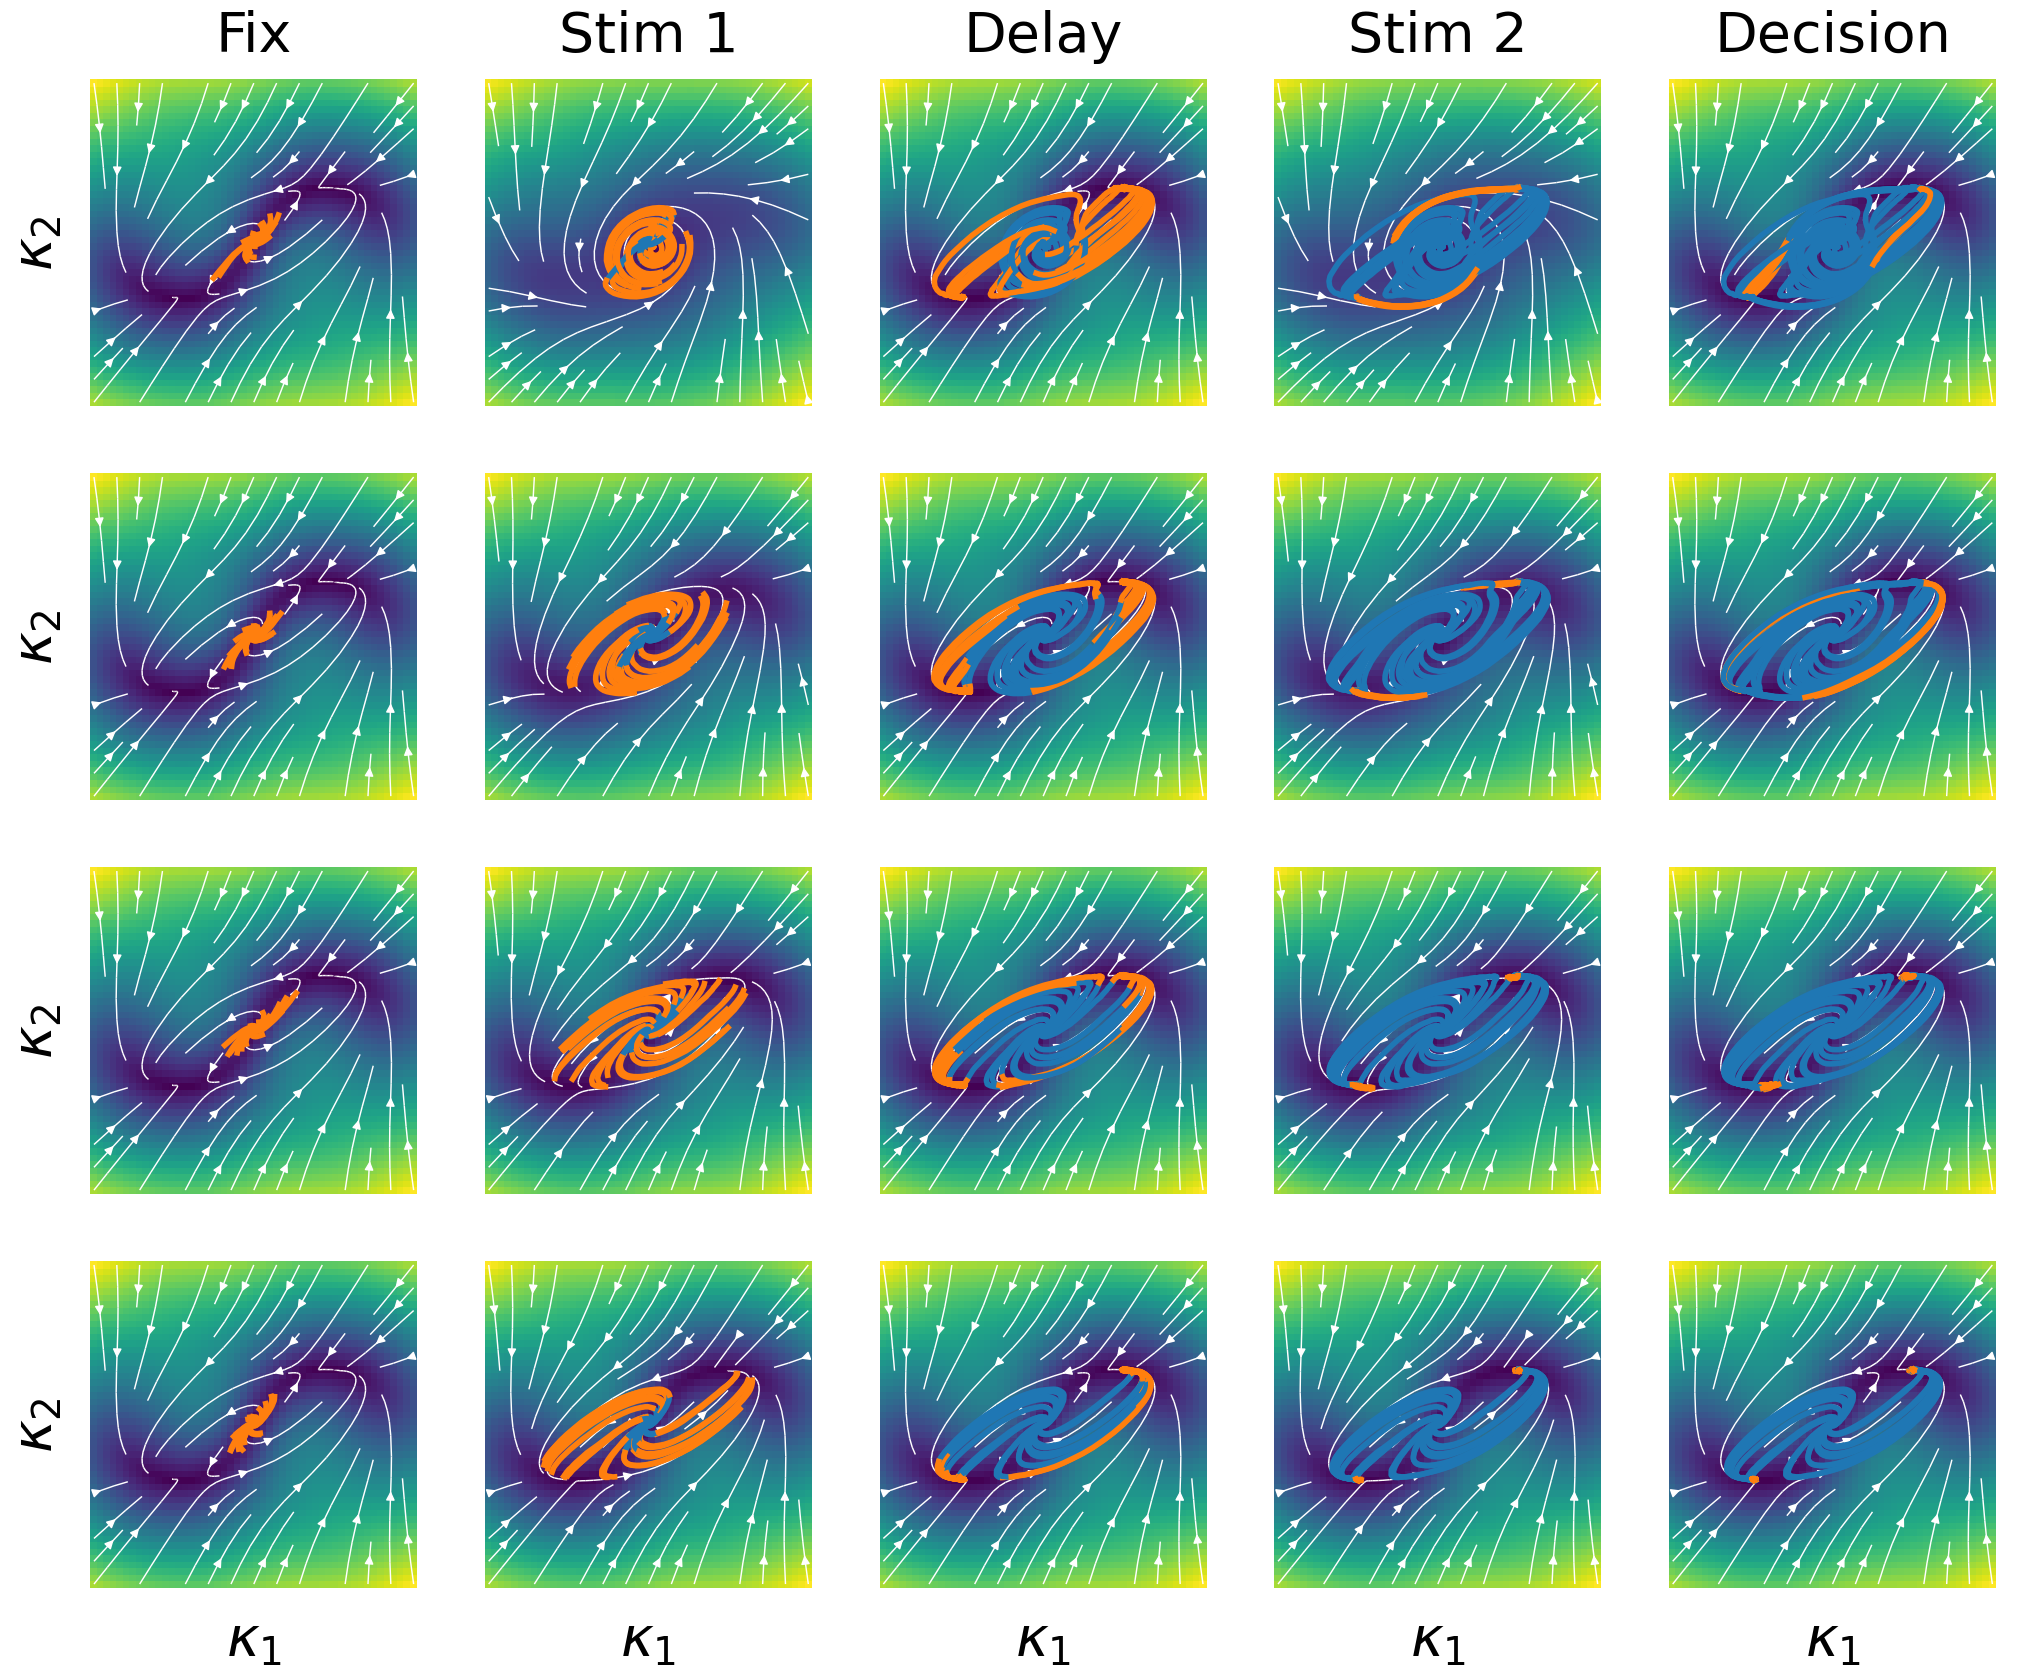

In [19]:
fig, ax = plt.subplots(4, 5, figsize=(25, 20))
dms.plot_trajectories_steps_ranktwo(net, scalings=False, n_traj=20, rect=(-5, 5, -4, 4), ax=ax, sizes=1.3)

ax[0][0].set_title('Fix')
ax[0][1].set_title('Stim 1')
ax[0][2].set_title('Delay')
ax[0][3].set_title('Stim 2')
ax[0][4].set_title('Decision')

for i in range(4):
    ax[i][0].set_ylabel('$\kappa_2$')
for i in range(5):
    ax[3][i].set_xlabel('$\kappa_1$')
    
fig.subplots_adjust(hspace=.1, wspace=.1)
# plt.savefig('figures/si_dms_epochs.pdf')

# Plot phase portraits of the resampled system for various parameters

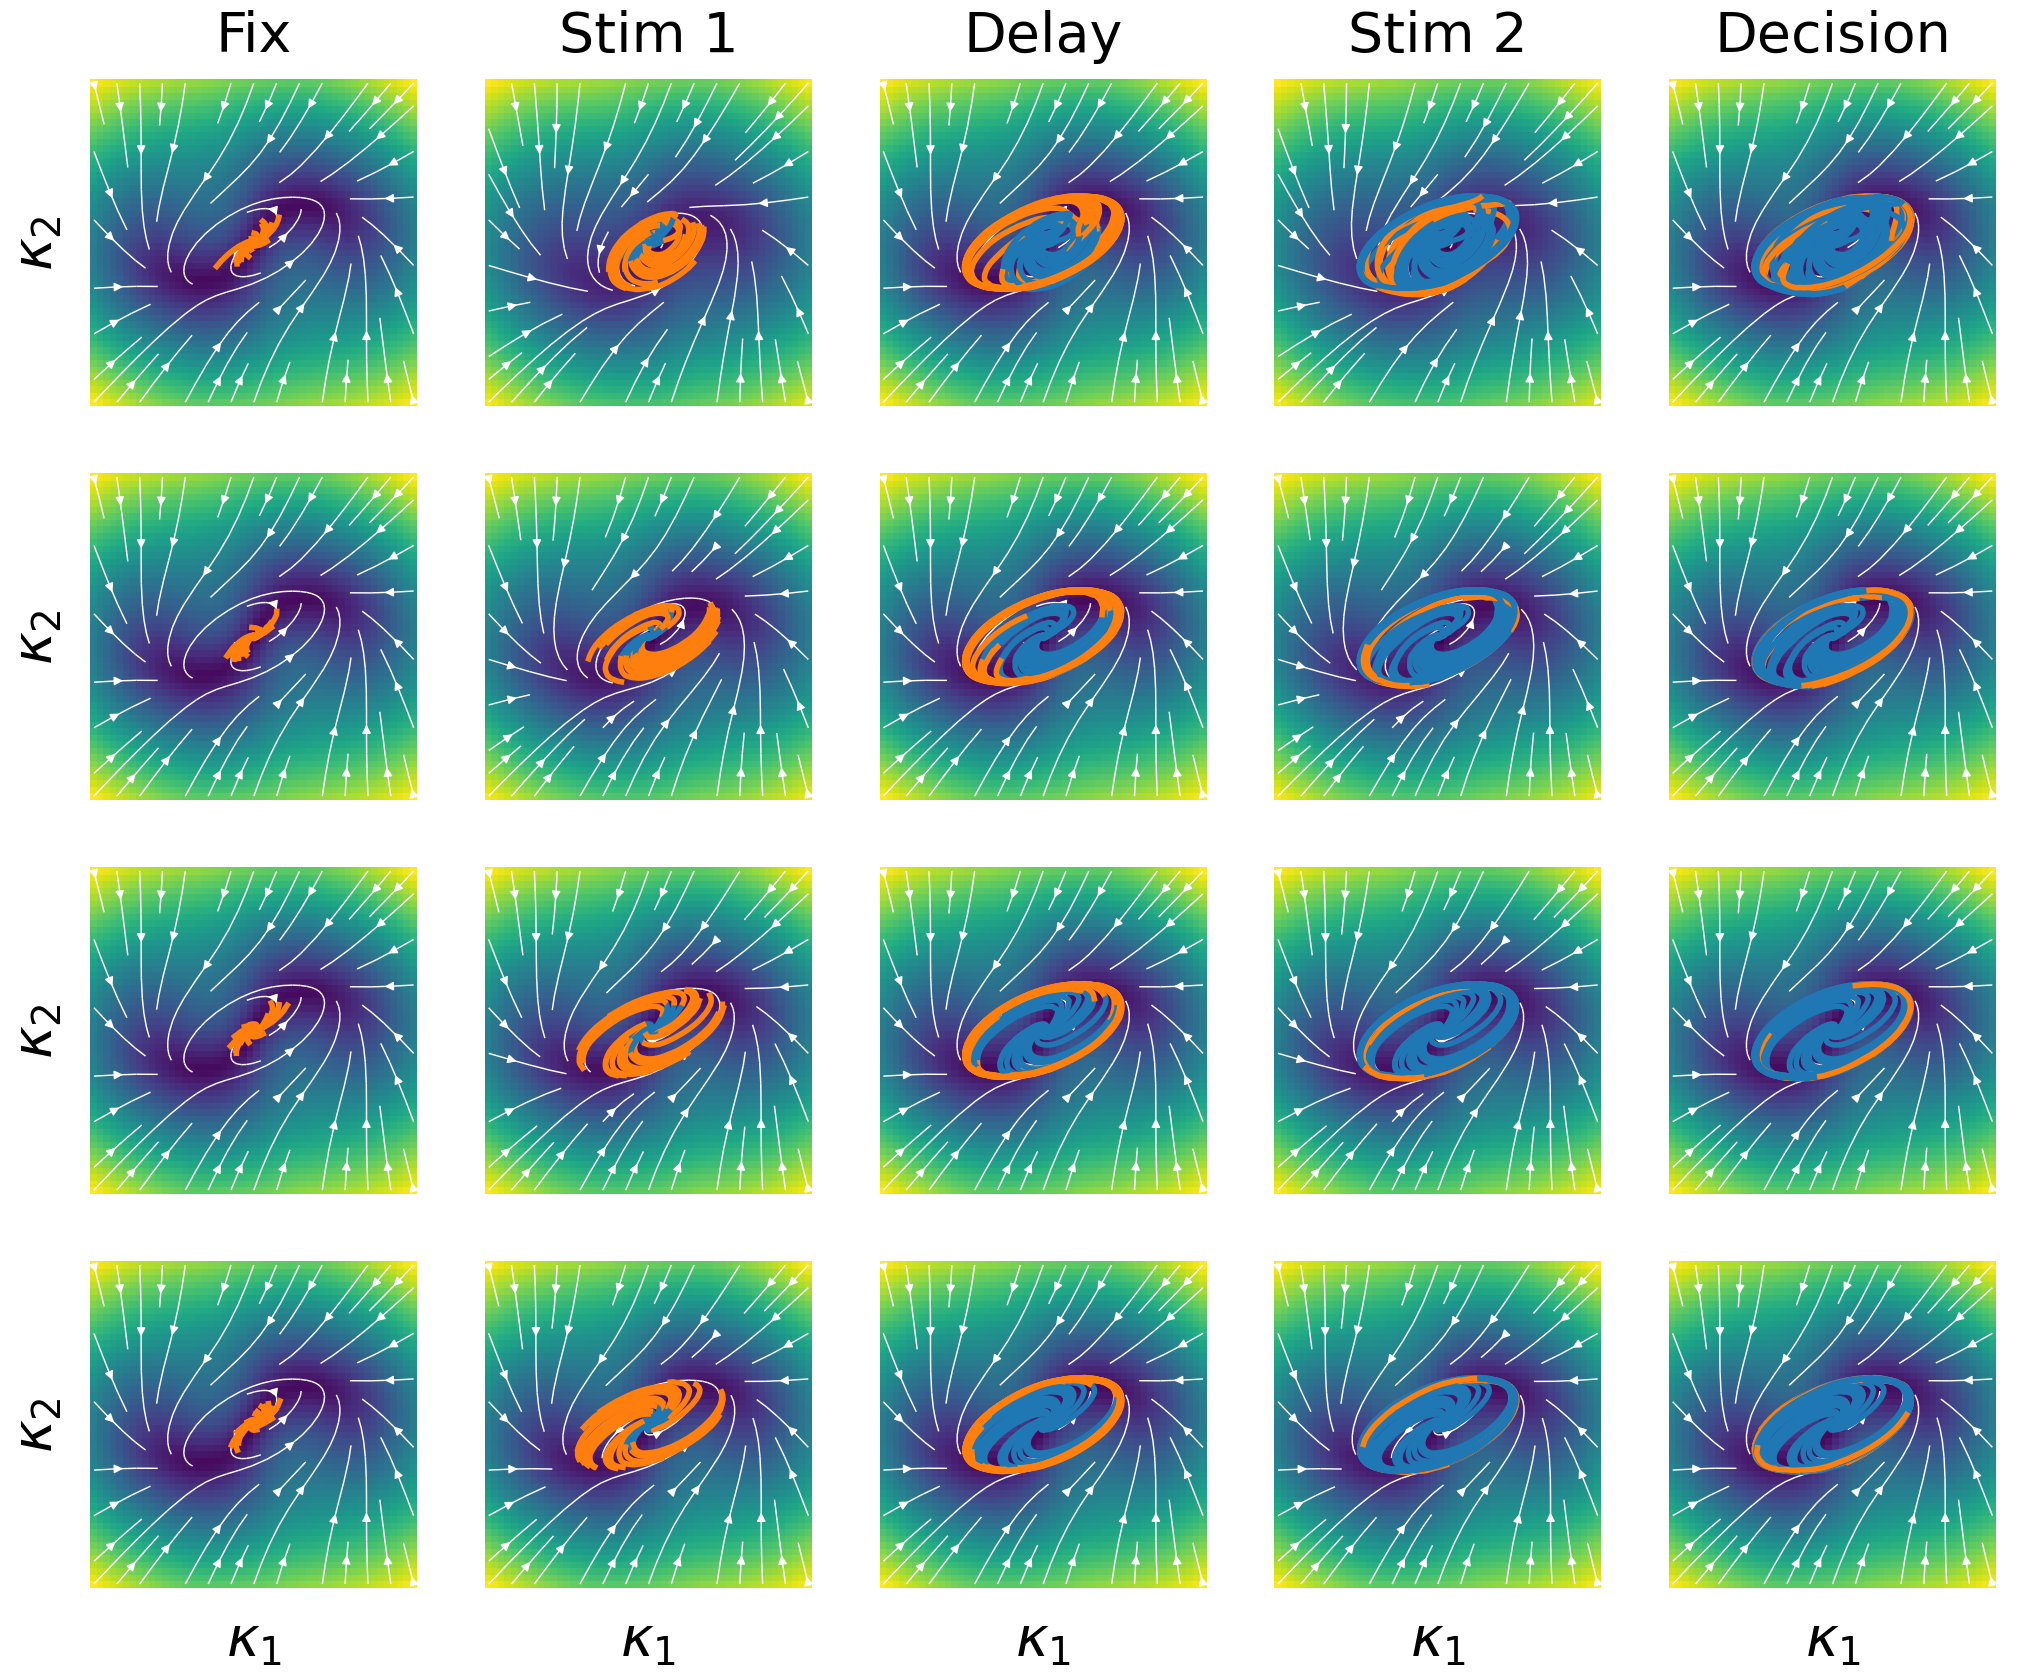

In [20]:
fig, ax = plt.subplots(4, 5, figsize=(25, 20))
dms.plot_trajectories_steps_ranktwo(net3, scalings=False, n_traj=20, rect=(-5, 5, -4, 4), ax=ax, sizes=1.3)

ax[0][0].set_title('Fix')
ax[0][1].set_title('Stim 1')
ax[0][2].set_title('Delay')
ax[0][3].set_title('Stim 2')
ax[0][4].set_title('Decision')

for i in range(4):
    ax[i][0].set_ylabel('$\kappa_2$')
for i in range(5):
    ax[3][i].set_xlabel('$\kappa_1$')
    
fig.subplots_adjust(hspace=.1, wspace=.1)